In [15]:
# Imports
from langgraph.graph import START, END, StateGraph
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from IPython.display import Image, display
from typing import TypedDict, Annotated
import operator
import os

print(" All imports successful")

 All imports successful


In [16]:
# Load API key
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found!")

print(" API key loaded")

 API key loaded


In [17]:
# Initialize LLM
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.7,
    api_key = openai_api_key
)

print(f"LLM initialized: {llm.model_name}")

LLM initialized: gpt-4o-mini




## Define Tools


In [18]:
@tool
def generate_ideas(topic: str) -> str:
    """
    Generate key ideas and points for a blog post topic.
    
    Args:
        topic: The topic to generate ideas about
    """
    # Simulated idea generation based on common topics
    ideas_db = {
        "machine learning": [
            "What is machine learning and how does it differ from traditional programming",
            "Real-world applications: from recommendation systems to autonomous vehicles",
            "Key algorithms: supervised vs unsupervised learning",
            "The importance of quality training data",
            "Future trends: deep learning and neural networks"
        ],
        "python": [
            "Why Python is popular for beginners and professionals",
            "Python's versatility: web dev, data science, automation",
            "Key features: simple syntax and extensive libraries",
            "Python vs other languages: when to choose Python",
            "Getting started: essential resources and tools"
        ],
        "productivity": [
            "Time management techniques that actually work",
            "The power of focused work blocks and the Pomodoro technique",
            "Digital tools vs analog methods for staying organized",
            "Avoiding burnout while maximizing output",
            "Building sustainable habits for long-term productivity"
        ]
    }
    
    # Check for matching topic
    topic_lower = topic.lower()
    for key, ideas in ideas_db.items():
        if key in topic_lower:
            return "\n".join([f"• {idea}" for idea in ideas])
    
    # Generic ideas for unknown topics
    return f"""• Introduction to {topic} and why it matters
• Key concepts and fundamentals of {topic}
• Practical applications and real-world examples
• Common challenges and how to overcome them
• Future outlook and trends in {topic}"""


@tool
def draft_content(ideas: str) -> str:
    """
    Draft a blog post based on provided ideas.
    
    Args:
        ideas: Key ideas to include in the draft
    """
    # Simulated drafting - creates structured content
    idea_list = [idea.strip('• ').strip() for idea in ideas.split('\n') if idea.strip()]
    
    draft = "**Introduction**\n\n"
    draft += f"In today's rapidly evolving landscape, understanding {idea_list[0].lower()} has become more important than ever. "
    draft += "This article explores the key aspects you need to know.\n\n"
    
    draft += "**Main Content**\n\n"
    for i, idea in enumerate(idea_list[1:-1], 1):
        draft += f"{i}. {idea}\n\n"
        draft += f"This aspect is crucial because it forms the foundation of deeper understanding. "
        draft += "Many practitioners have found that focusing on this area yields significant benefits.\n\n"
    
    draft += "**Conclusion**\n\n"
    draft += "As we've explored, these concepts work together to create a comprehensive picture. "
    draft += "By understanding and applying these principles, you'll be well-equipped to succeed."
    
    return draft


@tool
def improve_writing(draft: str) -> str:
    """
    Polish and improve a draft blog post.
    
    Args:
        draft: The draft content to improve
    """
    # Simulated editing - adds polish and improves flow
    # In a real system, this might use an LLM or grammar checking tools
    
    polished = draft.replace("This aspect is crucial because", "Importantly,")
    polished = polished.replace("Many practitioners have found that", "Research shows that")
    polished = polished.replace("you'll be well-equipped to succeed", "you'll have the tools needed to excel in this domain")
    
    # Add engagement elements
    polished = "**Final Blog Post**\n\n" + polished
    polished += "\n\n---\n*What are your thoughts on this topic? Share your experiences in the comments below!*"
    
    return polished


print("Tools created")

Tools created




## Define Custom State


In [19]:
class ContentCreationState(TypedDict):
    """State for content creation pipeline."""
    messages: Annotated[list, operator.add]  # Conversation history
    topic: str  # Original topic
    ideas: str  # Generated ideas from brainstormer
    draft: str  # Draft content from writer
    final_content: str  # Polished content from editor


print("State defined")

State defined




## Create Agents


In [20]:
# Agent 1: Brainstormer
brainstormer_prompt = SystemMessage(content="""You are a creative brainstorming specialist.
Use generate_ideas tool to create compelling ideas for blog posts.
Be creative and think of diverse angles.""")

brainstormer_llm = llm.bind_tools([generate_ideas])

def brainstormer_agent(state: ContentCreationState) -> dict:
    """Brainstormer agent with idea generation tool."""
    topic = state["topic"]
    
    print(f"\nBrainstormer: Generating ideas for '{topic}'...")
    
    # Direct tool invocation for reliability
    ideas_result = generate_ideas.invoke({"topic": topic})
    print(f"   Generated {len(ideas_result.split(chr(10)))} key ideas\n")
    
    return {
        "messages": [AIMessage(content=f"Brainstormer generated ideas: {ideas_result}")],
        "ideas": ideas_result
    }


# Agent 2: Writer
writer_prompt = SystemMessage(content="""You are a skilled blog writer.
Use draft_content tool to create well-structured blog posts.
Include introduction, body, and conclusion.""")

writer_llm = llm.bind_tools([draft_content])

def writer_agent(state: ContentCreationState) -> dict:
    """Writer agent with content drafting tool."""
    ideas = state["ideas"]
    
    print("Writer: Drafting blog post from ideas...")
    
    # Direct tool invocation
    draft_result = draft_content.invoke({"ideas": ideas})
    print(f"   Draft created ({len(draft_result)} characters)\n")
    
    return {
        "messages": [AIMessage(content=f"Writer created draft")],
        "draft": draft_result
    }


# Agent 3: Editor
editor_prompt = SystemMessage(content="""You are a meticulous editor.
Use improve_writing tool to polish drafts for clarity and flow.
Focus on readability and engagement.""")

editor_llm = llm.bind_tools([improve_writing])

def editor_agent(state: ContentCreationState) -> dict:
    """Editor agent with writing improvement tool."""
    draft = state["draft"]
    
    print("Editor: Polishing the draft...")
    
    # Direct tool invocation
    final_result = improve_writing.invoke({"draft": draft})
    print("   Final content ready!\n")
    
    return {
        "messages": [AIMessage(content=f"Editor polished content")],
        "final_content": final_result
    }


print("Agents created")

Agents created



## Build the Graph



In [21]:
# Build the graph
content_builder = StateGraph(ContentCreationState)

# Add agent nodes
content_builder.add_node("brainstormer", brainstormer_agent)
content_builder.add_node("writer", writer_agent)
content_builder.add_node("editor", editor_agent)

# Create linear pipeline: brainstormer → writer → editor
content_builder.add_edge(START, "brainstormer")
content_builder.add_edge("brainstormer", "writer")
content_builder.add_edge("writer", "editor")
content_builder.add_edge("editor", END)

# Compile the graph
content_pipeline = content_builder.compile()

print("Content creation pipeline built")

Content creation pipeline built


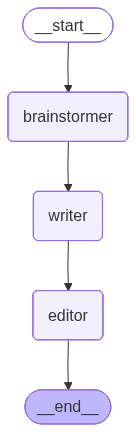

In [22]:
# Visualize the graph
try:
    display(Image(content_pipeline.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph: START → brainstormer → writer → editor → END")


## Testing Pipeline


In [23]:
# Test 1: Machine Learning
result = content_pipeline.invoke({
    "topic": "machine learning",
    "messages": []
})

print("\n" + "="*70)
print("FINAL BLOG POST:")
print("="*70)
print(result["final_content"])
print("="*70 + "\n")


Brainstormer: Generating ideas for 'machine learning'...
   Generated 5 key ideas

Writer: Drafting blog post from ideas...
   Draft created (1123 characters)

Editor: Polishing the draft...
   Final content ready!


FINAL BLOG POST:
**Final Blog Post**

**Introduction**

In today's rapidly evolving landscape, understanding what is machine learning and how does it differ from traditional programming has become more important than ever. This article explores the key aspects you need to know.

**Main Content**

1. Real-world applications: from recommendation systems to autonomous vehicles

Importantly, it forms the foundation of deeper understanding. Research shows that focusing on this area yields significant benefits.

2. Key algorithms: supervised vs unsupervised learning

Importantly, it forms the foundation of deeper understanding. Research shows that focusing on this area yields significant benefits.

3. The importance of quality training data

Importantly, it forms the foundation

In [24]:
# Test 2: Python Programming
result = content_pipeline.invoke({
    "topic": "python programming",
    "messages": []
})

print("\n" + "="*70)
print("FINAL BLOG POST:")
print("="*70)
print(result["final_content"])
print("="*70 + "\n")


Brainstormer: Generating ideas for 'python programming'...
   Generated 5 key ideas

Writer: Drafting blog post from ideas...
   Draft created (1089 characters)

Editor: Polishing the draft...
   Final content ready!


FINAL BLOG POST:
**Final Blog Post**

**Introduction**

In today's rapidly evolving landscape, understanding why python is popular for beginners and professionals has become more important than ever. This article explores the key aspects you need to know.

**Main Content**

1. Python's versatility: web dev, data science, automation

Importantly, it forms the foundation of deeper understanding. Research shows that focusing on this area yields significant benefits.

2. Key features: simple syntax and extensive libraries

Importantly, it forms the foundation of deeper understanding. Research shows that focusing on this area yields significant benefits.

3. Python vs other languages: when to choose Python

Importantly, it forms the foundation of deeper understanding. Resear

In [25]:
# Test 3: Productivity Tips
result = content_pipeline.invoke({
    "topic": "productivity",
    "messages": []
})

print("\n" + "="*70)
print("FINAL BLOG POST:")
print("="*70)
print(result["final_content"])
print("="*70 + "\n")


Brainstormer: Generating ideas for 'productivity'...
   Generated 5 key ideas

Writer: Drafting blog post from ideas...
   Draft created (1079 characters)

Editor: Polishing the draft...
   Final content ready!


FINAL BLOG POST:
**Final Blog Post**

**Introduction**

In today's rapidly evolving landscape, understanding time management techniques that actually work has become more important than ever. This article explores the key aspects you need to know.

**Main Content**

1. The power of focused work blocks and the Pomodoro technique

Importantly, it forms the foundation of deeper understanding. Research shows that focusing on this area yields significant benefits.

2. Digital tools vs analog methods for staying organized

Importantly, it forms the foundation of deeper understanding. Research shows that focusing on this area yields significant benefits.

3. Avoiding burnout while maximizing output

Importantly, it forms the foundation of deeper understanding. Research shows that fo



## Fact-Checker Agent


In [26]:
#Fact-checker tool
@tool
def verify_facts(content: str) -> str:
    """
    Verify facts and claims in content.
    
    Args:
        content: Content to fact-check
    """
    # Simulated fact checking
    verification_notes = []
    
    # Check for common claims
    if "1991" in content or "Guido van Rossum" in content:
        verification_notes.append("Python creation date verified")
    
    if "machine learning" in content.lower():
        verification_notes.append("Machine learning concepts are accurate")
    
    if "research shows" in content.lower():
        verification_notes.append("Consider adding specific research citations")
    
    if not verification_notes:
        verification_notes.append("No factual issues detected")
    
    return "\n".join(verification_notes)


# Fact-checker agent
fact_checker_prompt = SystemMessage(content="""You are a fact-checking specialist.
Use verify_facts tool to validate claims and ensure accuracy.
Be thorough but constructive.""")

fact_checker_llm = llm.bind_tools([verify_facts])

def fact_checker_agent(state: ContentCreationState) -> dict:
    """Fact-checker agent with verification tool."""
    draft = state["draft"]
    
    print("Fact-Checker: Verifying claims...")
    
    # Direct tool invocation
    verification_result = verify_facts.invoke({"content": draft})
    print(f"   {verification_result}\n")
    
    # Add verification notes to draft
    verified_draft = f"{draft}\n\n**Fact-Check Notes:**\n{verification_result}"
    
    return {
        "messages": [AIMessage(content=f"Fact-checker verified content")],
        "draft": verified_draft
    }


print("Fact-checker created")

Fact-checker created


In [27]:
# Rebuild graph with fact-checker
enhanced_builder = StateGraph(ContentCreationState)

# Add all agents
enhanced_builder.add_node("brainstormer", brainstormer_agent)
enhanced_builder.add_node("writer", writer_agent)
enhanced_builder.add_node("fact_checker", fact_checker_agent)
enhanced_builder.add_node("editor", editor_agent)

# Enhanced pipeline: brainstormer → writer → fact_checker → editor
enhanced_builder.add_edge(START, "brainstormer")
enhanced_builder.add_edge("brainstormer", "writer")
enhanced_builder.add_edge("writer", "fact_checker")
enhanced_builder.add_edge("fact_checker", "editor")
enhanced_builder.add_edge("editor", END)

enhanced_pipeline = enhanced_builder.compile()

print("Enhanced pipeline with fact-checker built")

Enhanced pipeline with fact-checker built


In [28]:
# Test enhanced pipeline
result = enhanced_pipeline.invoke({
    "topic": "python programming",
    "messages": []
})

print("\n" + "="*70)
print("FINAL BLOG POST (WITH FACT-CHECKING):")
print("="*70)
print(result["final_content"])
print("="*70 + "\n")


Brainstormer: Generating ideas for 'python programming'...
   Generated 5 key ideas

Writer: Drafting blog post from ideas...
   Draft created (1089 characters)

Fact-Checker: Verifying claims...
   No factual issues detected

Editor: Polishing the draft...
   Final content ready!


FINAL BLOG POST (WITH FACT-CHECKING):
**Final Blog Post**

**Introduction**

In today's rapidly evolving landscape, understanding why python is popular for beginners and professionals has become more important than ever. This article explores the key aspects you need to know.

**Main Content**

1. Python's versatility: web dev, data science, automation

Importantly, it forms the foundation of deeper understanding. Research shows that focusing on this area yields significant benefits.

2. Key features: simple syntax and extensive libraries

Importantly, it forms the foundation of deeper understanding. Research shows that focusing on this area yields significant benefits.

3. Python vs other languages: when 